In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoARIMA, SeasonalNaive, TBATS,OptimizedTheta,SeasonalExponentialSmoothingOptimized
import seaborn as sns
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)
import warnings 
warnings.filterwarnings('ignore') 

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load and prepare dataset
df = pd.read_csv('data.csv')

df.columns = [col.replace(".","_") for col in df.columns]

df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "",regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "",regex=True).astype("int16")
df["Day_Of_Week"] = df["Day_Of_Week"].astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].str.replace(",", "",regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].str.replace(",", "",regex=True).astype("int16")
df["unique_id"] = "1"

df.drop(columns="Row",inplace=True)
df.drop(columns="Day",inplace=True)
df.drop(columns="Day_Of_Week",inplace=True)





#df = df.rename(columns={'Date': 'ds', 'Page_Loads': 'y'})

print(df.describe())

# Splitting the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]


                      Date   Page_Loads  Unique_Visits  First_Time_Visits  \
count                 2167  2167.000000    2167.000000        2167.000000   
mean   2017-09-01 00:00:00  4116.989386    2943.646516        2431.824181   
min    2014-09-14 00:00:00  1002.000000     667.000000         522.000000   
25%    2016-03-08 12:00:00  3114.500000    2226.000000        1830.000000   
50%    2017-09-01 00:00:00  4106.000000    2914.000000        2400.000000   
75%    2019-02-24 12:00:00  5020.500000    3667.500000        3038.000000   
max    2020-08-19 00:00:00  7984.000000    5541.000000        4616.000000   
std                    NaN  1350.977843     977.886472         828.704688   

       Returning_Visits  
count       2167.000000  
mean         511.822335  
min          133.000000  
25%          388.500000  
50%          509.000000  
75%          626.500000  
max         1036.000000  
std          168.736370  


In [2]:
from prophet import Prophet
# Initialize and fit the Prophet model on the TRAINING data
model = Prophet()
model.fit(train_df)

# Create a future dataframe that covers the period of the test set
# Note: The test set's period is essentially from the last point in the training set to the end of the test set.
last_train_date = train_df['ds'].max()
first_test_date = test_df['ds'].min()
last_test_date = test_df['ds'].max()

# Ensure the future dataframe includes the test set period
future_dates = model.make_future_dataframe(periods=(last_test_date - last_train_date).days + 1, include_history=False)

# Predict the future with the model
forecast_prophet = model.predict(future_dates)
#print(forecast_prophet)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

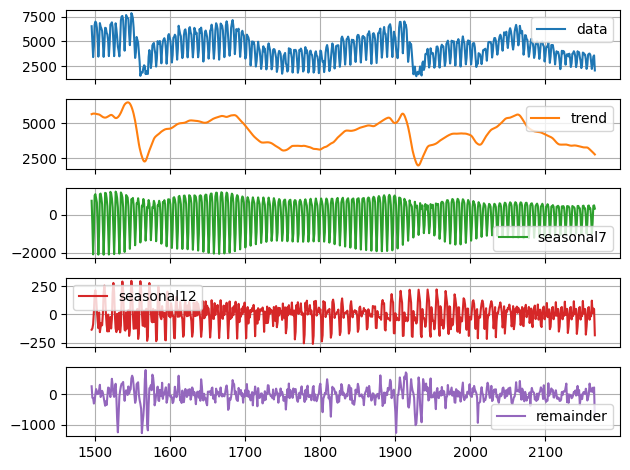

             ds     y unique_id
2017 2020-03-23  4105         1
2018 2020-03-24  4156         1
2019 2020-03-25  4153         1
2020 2020-03-26  4256         1
2021 2020-03-27  3818         1
          ds     y unique_id
0 2014-09-14  2146         1
1 2014-09-15  3621         1
2 2014-09-16  3698         1
3 2014-09-17  3667         1
4 2014-09-18  3316         1
                  ds         MSTL  SeasonalNaive  OptimizedTheta    SeasESOpt  \
unique_id                                                                       
1         2032-04-30  1519.830566         4393.0     3192.174805  3934.911377   
1         2032-05-31  2211.847412         3316.0     3222.284180  3811.874268   
1         2032-06-30  3620.491211         2416.0     3249.052979  4028.263672   
1         2032-07-31  3836.817383         2934.0     3250.938965  4026.663330   
1         2032-08-31  3557.709717         2732.0     3198.424561  3795.333008   

                 TBATS  
unique_id               
1          2828.

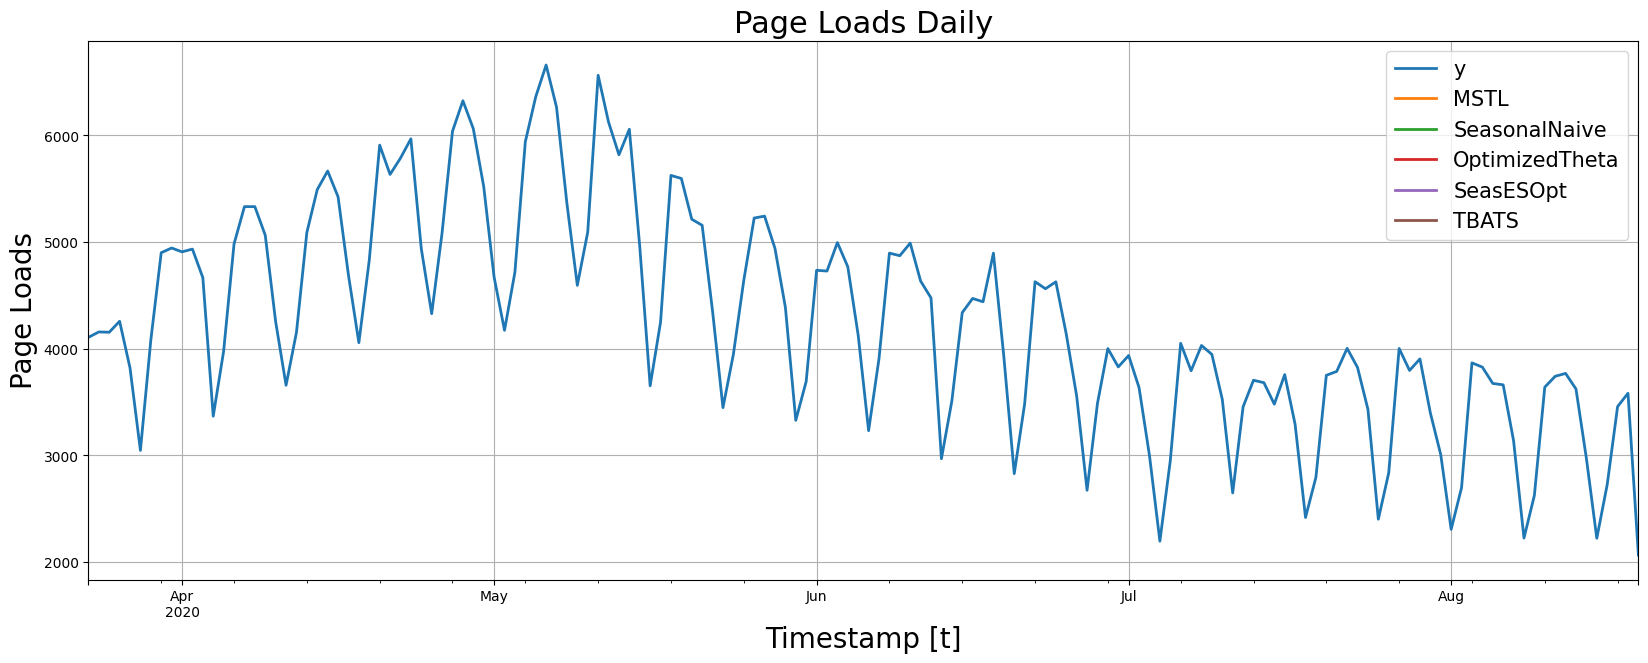

In [39]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

df.set_index("Date",inplace=True)
df.sort_index(inplace=True)

df_pl = df[["Page_Loads"]]


#print(df_pl.head())

def transform_dataframe(df,target_column):
    df_transformed = df.reset_index()
    df_transformed.rename(columns={"Date": "ds", target_column: "y"}, inplace=True)
    df_transformed["unique_id"] = "1"
    return df_transformed
df_pl_transformed = transform_dataframe(df_pl,target_column="Page_Loads")

#print(df_pl_transformed.head())

#print(df_pl_transformed.tail(30))

mstl = MSTL(
    season_length=[7,12], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

season_length = 12
sf = StatsForecast(
    models=[mstl, SeasonalNaive(season_length=season_length),
            OptimizedTheta(season_length=season_length,decomposition_type="additive"),
            SeasonalExponentialSmoothingOptimized(season_length=season_length),TBATS(seasonal_periods=season_length)
        ],
    freq=""
)

def plot_forecasts(y_hist, y_true, y_pred, models,target_name):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(30*5)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
  
    ax.set_title(f"{target_name} Daily", fontsize=22)
    ax.set_ylabel(f"{target_name}", fontsize=20)
    ax.set_xlabel("Timestamp [t]", fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()
        
sf = sf.fit(df=df_pl_transformed)

sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True,)
plt.tight_layout()
plt.show()
df_test = df_pl_transformed.tail(150)
df_train = df_pl_transformed.drop(df_test.index)
print(df_test.head())
print(df_train.head())
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test))
print(forecasts_test.tail())
plot_forecasts(df_train, df_test, forecasts_test, models=["MSTL", "SeasonalNaive","OptimizedTheta","SeasESOpt","TBATS"],target_name="Page Loads")

# Fit the model on the training DataFrame
#sf.fit(train_df[])

# Predict the future values
#forecast_nixtla = sf.predict(h=len(test_df))
#print(forecast_nixtla)
#print(forecast_nixtla.head())
#print(forecast_nixtla.columns)
#print(forecast_nixtla.index.names)



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
import seaborn as sns

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('data.csv')

# Rename columns to replace "." with "_"
df.columns = [col.replace(".", "_") for col in df.columns]

# Data type conversion and preprocessing
df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "", regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "", regex=True).astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].replace(",", "", regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].replace(",", "", regex=True).astype("int16")

# Dropping unnecessary columns and setting index
df.drop(columns=["Row", "Day", "Day_Of_Week", "Unique_Visits", "First_Time_Visits", "Returning_Visits"], inplace=True)
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)


In [5]:
# Prepare data for Prophet
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Page_Loads': 'y'})

# Splitting the dataset
train_size = int(len(df_prophet) * 0.8)
train_df_prophet = df_prophet[:train_size]
test_df_prophet = df_prophet[train_size:]

# Initialize and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_df_prophet)

# Create a future dataframe for Prophet predictions
future_dates_prophet = model_prophet.make_future_dataframe(periods=len(test_df_prophet), include_history=False)
forecast_prophet = model_prophet.predict(future_dates_prophet)


13:38:59 - cmdstanpy - INFO - Chain [1] start processing
13:38:59 - cmdstanpy - INFO - Chain [1] done processing


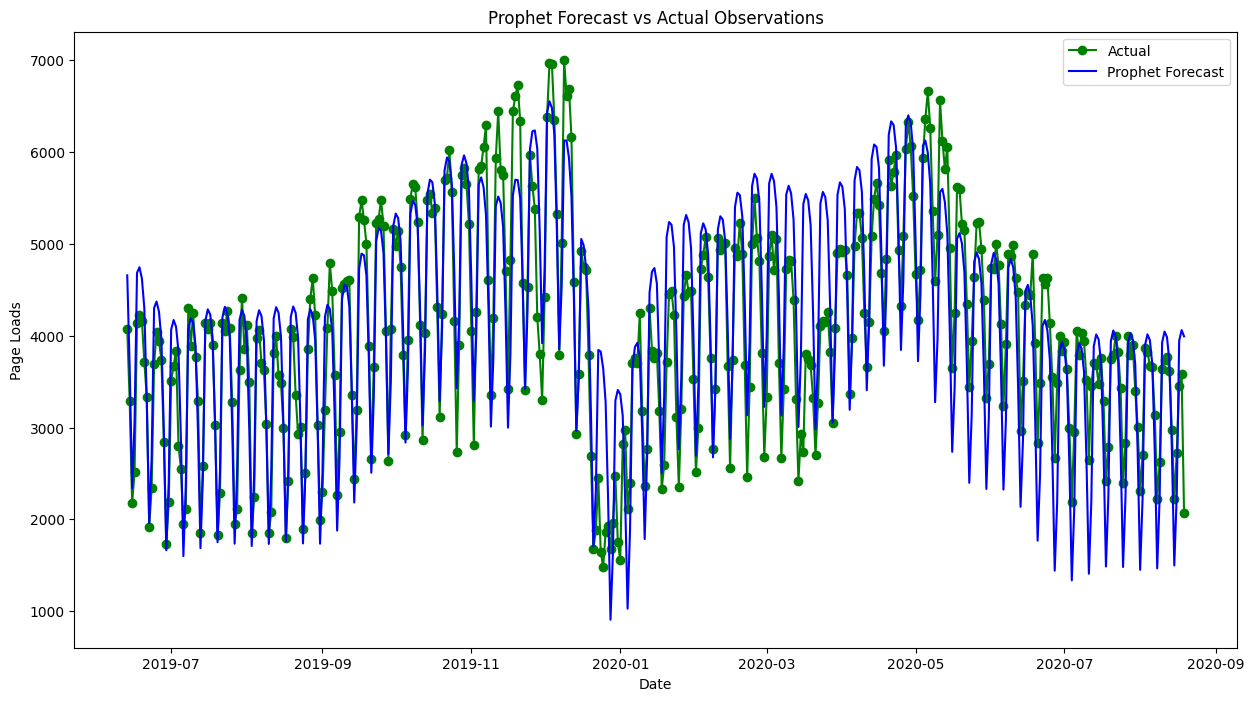

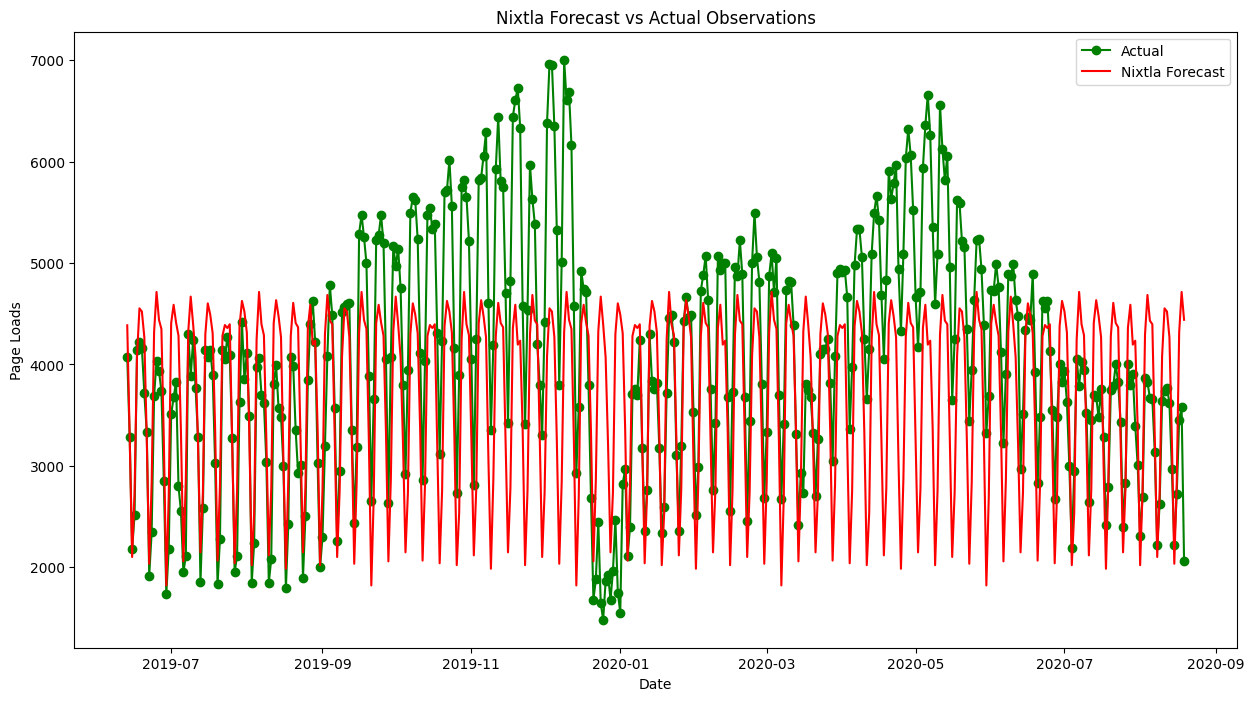

In [25]:
# Plotting the Prophet forecast
plt.figure(figsize=(15, 8))
plt.plot(test_df_prophet['ds'], test_df_prophet['y'], label='Actual', color='green', marker='o')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='blue')
plt.title('Prophet Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

# Plotting the Nixtla forecast
plt.figure(figsize=(15, 8))
plt.plot(test_df_nixtla['ds'], test_df_nixtla['y'], label='Actual', color='green', marker='o')
plt.plot(forecasts_nixtla['ds'], forecasts_nixtla['MSTL'], label='Nixtla Forecast', color='red')
plt.title('Nixtla Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()